In [1]:
!pip install -q chromadb
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install -q transformers
!pip install -q langchain
!pip install -q sentence_transformers
!pip install -q unstructured
!pip install -q bitsandbytes
!pip install -q accelerate
!pip install -U -q langchain-community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.8/526.8 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.1/106.1 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.7/283.7 kB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.

In [ ]:
!transformers-cli env


Copy-and-paste the text below in your GitHub issue and FILL OUT the two last points.

- `transformers` version: 4.41.1
- Platform: Windows-10-10.0.22621-SP0
- Python version: 3.11.9
- Huggingface_hub version: 0.23.1
- Safetensors version: 0.4.3
- Accelerate version: not installed
- Accelerate config: not found
- PyTorch version (GPU?): 2.3.0+cu121 (True)
- Tensorflow version (GPU?): not installed (NA)
- Flax version (CPU?/GPU?/TPU?): not installed (NA)
- Jax version: not installed
- JaxLib version: not installed
- Using GPU in script?: <fill in>
- Using distributed or parallel set-up in script?: <fill in>



In [2]:
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    pipeline,
)

In [3]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [4]:
#################################################################
# Tokenizer
#################################################################

model_name='meta-llama/Meta-Llama-3-8B-Instruct'

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
#################################################################
# bitsandbytes parameters
#################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "bfloat16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

# Device partition
device_map = "auto"

In [6]:
#################################################################
# Set up quantization config
#################################################################
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

In [7]:
#################################################################
# Load pre-trained config
#################################################################
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    low_cpu_mem_usage = True,
    device_map = "auto"
)

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

## LangChain

In [11]:
# Paths to the database and the data

CHROMA_PATH = "chroma"
DATA_PATH = "data"

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
%cd /content/drive/My Drive/Colab Notebooks/

/content/drive/My Drive/Colab Notebooks


In [13]:
from bs4 import BeautifulSoup
import os

def XMLLoader(folder_path):
    reportData_list = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.xml'):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r') as file:
                content = file.read()

            soup = BeautifulSoup(content, 'xml')

            reportData = {}
            for tag in soup.find_all():
                if tag.name != "report":
                    reportData[tag.name] = tag.text.strip()

            reportData["filename"] = filename
            reportData_list.append(reportData)

    return reportData_list

In [14]:
data =  XMLLoader("data")

In [15]:
from langchain.docstore.document import Document

documents = []
for doc in data:

    document = Document(page_content=doc["report_text"], metadata={"source": doc["filename"],
                                                                   "subtype": doc["subtype"],
                                                                   "type": doc["type"],
                                                                   "chief_complaint": doc["chief_complaint"],
                                                                   "admit_diagnosis": doc["admit_diagnosis"],
                                                                   "discharge_diagnosis": doc["discharge_diagnosis"],
                                                                   "year": doc["year"],
                                                                   "downlaod_time": doc.get("download_time", ""), # Algunos no tiemem este campo
                                                                   "deid": doc["deid"]})
    documents.append(document)

In [ ]:
#documents[1].metadata["subtype"]="TEST"
#print(documents[7])

Text split

In [20]:
from langchain.vectorstores.chroma import Chroma
from langchain.embeddings import SentenceTransformerEmbeddings
from sentence_transformers import SentenceTransformer
import shutil

embedding_model = "BAAI/bge-small-en-v1.5"

# Clear out the database first if already exists.
if os.path.exists(CHROMA_PATH):
    shutil.rmtree(CHROMA_PATH)

# https://huggingface.co/sentence-transformers
# https://huggingface.co/spaces/mteb/leaderboard
embeddings = SentenceTransformerEmbeddings(model_name=embedding_model)

print(f"Model's max seq length: {SentenceTransformer('BAAI/bge-small-en-v1.5').max_seq_length}")

# Estos dos parámetros determinarán el tamaño de los chunks
# Embedding dimensions: 384 (Dimensión de los embeddings en el espacio vectorial)
# Max tokens: 512 (Max tokens que le puedes meter al modelo de embeddings)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model's max seq length: 512


In [23]:
import matplotlib.pyplot as plt
import pandas as pd

# Por defecto, los chunks se dividiran en 2500 caracteres. Al pasarlo a tokens, obtenemos la siguiente gráfica.

def plot_docs_tokens(docs_processed):
  tokenizer = AutoTokenizer.from_pretrained(embedding_model)
  lengths = [
      len(tokenizer.encode(doc.page_content))
      for doc in docs_processed
  ]

  fig = pd.Series(lengths).hist()
  plt.show()

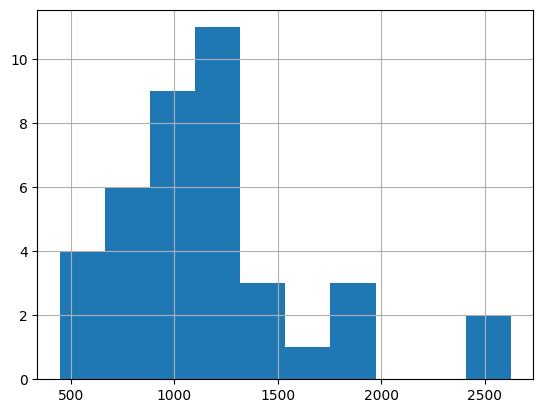

In [24]:
plot_docs_tokens(documents)

En el eje X la cantidad de tokens y en el eje y la cantidad de chunks con esos tokens.

Para solucionar el problema es mejor definir el tamaño de chunks en terminos de numero de tokens en vez de numero de caracteres.

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# LLama3 - Ventana de contexto de 8000 tokens
text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
    tokenizer,
    chunk_size=512,
    chunk_overlap=int(512 / 10),
    length_function=len,
    add_start_index=True
)

chunks = text_splitter.split_documents(documents)
print(f"Split {len(documents)} documents into {len(chunks)} chunks.")

In [ ]:
plot_docs_tokens(chunks)

In [ ]:
# Create a new DB from the documents.
db = Chroma.from_documents(
    chunks,
    embeddings,
    persist_directory=CHROMA_PATH
)

db.persist()
print(f"Saved {len(chunks)} chunks to {CHROMA_PATH}.")

# Cogemos un chunk aleatorio
document = chunks[10]
print(document.page_content) # Printeamos su contenido
print(document.metadata) # Y su metadata (Fichero al que pertenece y donde empieza 'start_index')



Split 39 documents into 545 chunks.
3. D5 half normal saline with 20 of K at 80 cc an hour.
4. Folic acid 1 mg daily.
5. Lasix 80 mg daily.
6. Heparin 5000 units subq q.12 h. 
7. Lantus insulin.
8. Sliding scale regular insulin.
9. Synthroid 50 mcg daily.
10. Metoprolol 25 mg daily.
11. Flagyl 500 mg IV q.8 h. 
12. Avelox 400 mg IV q. 24 h. 
13. Pravachol 20 mg daily.
14. Diovan 80 mg daily.
 
LABORATORY DATA 
Blood cultures are no growth today.  Sodium 137, potassium 4.4, chloride 109,
{'source': 'report10.xml', 'subtype': 'CONSULT', 'type': 'HP', 'chief_complaint': 'DIVERTICULITIS', 'admit_diagnosis': '562.10', 'discharge_diagnosis': '584.9,518.0,403.91,428.0,486,276.2,562.11,585.4,518.3,244.9,414.01,250.80,791.0,250.50,362.01,285.29,', 'year': '2007', 'downlaod_time': '', 'deid': 'v.6.22.07.0', 'start_index': 2901}


### Evaluator (For testing purposes)

In [ ]:
#Function to turn the word apple to a vector
from langchain.evaluation import load_evaluator

vector = embeddings.embed_query("almendras")
#print(f"Vector for 'apple': {vector}") # Algunos pueden ser muy largos
print(f"Vector length: {len(vector)}")

# Compare vector of two words (distance between two words)
# Esto nos ayudará a saber si dos palabras estas correlacionadas
# Si comparamos dos palabras iguales, la distancia será prácticamente 0
# Utilza por defecto OpenAI embeddings!
evaluator = load_evaluator("embedding_distance", embeddings=embeddings)

words = ("apple", "iphone")
x = evaluator.evaluate_strings(prediction=words[0], reference=words[1])
print(f"Comparing ({words[0]}, {words[1]}): {x}")

Vector length: 512
Comparing (apple, iphone): {'score': 0.30508241313171336}


In [ ]:
from langchain.llms import HuggingFacePipeline

# Pipeline for inference
def load_model():
    text_generation_pipeline = pipeline(
        model=model, # Model loaded in the first part
        tokenizer=tokenizer, # Tokenizer loaded in the first part
        task="text-generation",
        temperature=0.1,
        repetition_penalty=1.1,
        return_full_text=True,
        max_new_tokens=300,
        do_sample=True
    )

    hf = HuggingFacePipeline(pipeline=text_generation_pipeline)
    return hf

In [ ]:
llm = load_model()

In [ ]:
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain_core.output_parsers import StrOutputParser

def query_data(embeddings, llm):

    db = Chroma(persist_directory=CHROMA_PATH, embedding_function=embeddings)

    retriever = db.as_retriever(
        search_kwargs = {"k":3} # Para obtener los top 3 documentos mas reelevantes (Reranking)
    )

    # Similarity score threshold retrieval (Solo devuelve los chunks con 0.8 o mas de score de similitud)
    # naive_retriever = db.as_retriever(search_kwargs={"score_threshold": 0.8}, search_type="similarity_score_threshold")

    # Maximum marginal relevance retrieval
    # naive_retriever = db.as_retriever(search_type="mmr")

    prompt_template = """
    ### [INST]
    Act as an expert doctor. Use the medical reports provided below to answer the question.

    If you do not know the answer, or are unsure, say you don't know.

    {context}

    ### QUESTION:
    {question}

    [/INST]
     """

    promptTemplate = PromptTemplate(
        input_variables=["context", "question"],
        template=prompt_template
    )

    #llm_chain = LLMChain(llm=llm, prompt=promptTemplate)

    # RunnablePassthrough para pasar la query al siguiente step en la chain
    #rag_chain = (
    # {"context": retriever, "question": RunnablePassthrough()}
    #    | llm_chain
    #)



    setup_and_retrieval = RunnableParallel({"question": RunnablePassthrough(), "context": retriever })
    output_parser = StrOutputParser()

    # LCEL language to create the chain (de izquierda a derecha el output de uno se pasa al otro)
    parent_retrieval_chain = setup_and_retrieval | promptTemplate | llm | output_parser

    return parent_retrieval_chain

In [ ]:
chain = query_data(embeddings, llm)

In [ ]:
#import logging

#logging.basicConfig()
#logging.getLogger("langchain.retrievers.multi_query").setLevel(logging.INFO)

In [ ]:

out = chain.invoke("Wich patient has a history of cholecystectomy")
print(out)

In [ ]:
#rag_chain = query_data(embeddings, llm)
#query = """Explícame el artículo 32. Acceso a números o servicios"""
#answer = rag_chain.invoke(query)

In [ ]:
#answer['context']

[Document(page_content='mecanismos  de notificación  a que se refieren  los artículos  32, 33 y 34 del Código \nBOLETÍN OFICIAL DEL ESTADO\nNúm. 155 Miércoles 29 de junio de 2022 Sec. I.   Pág. 91386\ncve: BOE-A-2022-10757\nVerificable en https://www.boe.es', metadata={'page': 133, 'source': 'data/BOE-A-2022-10757.pdf', 'start_index': 0}),
 Document(page_content='que corresponda.\nBOLETÍN OFICIAL DEL ESTADO\nNúm. 155 Miércoles 29 de junio de 2022 Sec. I.   Pág. 91287\ncve: BOE-A-2022-10757\nVerificable en https://www.boe.es', metadata={'page': 34, 'source': 'data/BOE-A-2022-10757.pdf', 'start_index': 0}),
 Document(page_content='cualquier persona física o jurídica que desee contribuir, desinteresadamente, a la \nfinanciación de cualquier prestación propia del servicio universal.\nLos operadores sujetos a obligaciones de prestación del servicio universal recibirán \nde este fondo la cantidad correspondiente al coste neto que les supone dicha obligación, \ncalculado según el procedimient

In [ ]:
#answer['text']

"\n    ### [INST] Instrucción: Eres un experto en jurisdiccion, responde a la pregunta según tus conocimientos de jurisdiccion y el siguiente contexto:\n    \n    [Document(page_content='mecanismos  de notificación  a que se refieren  los artículos  32, 33 y 34 del Código \\nBOLETÍN OFICIAL DEL ESTADO\\nNúm. 155 Miércoles 29 de junio de 2022 Sec. I.   Pág. 91386\\ncve: BOE-A-2022-10757\\nVerificable en https://www.boe.es', metadata={'page': 133, 'source': 'data/BOE-A-2022-10757.pdf', 'start_index': 0}), Document(page_content='que corresponda.\\nBOLETÍN OFICIAL DEL ESTADO\\nNúm. 155 Miércoles 29 de junio de 2022 Sec. I.   Pág. 91287\\ncve: BOE-A-2022-10757\\nVerificable en https://www.boe.es', metadata={'page': 34, 'source': 'data/BOE-A-2022-10757.pdf', 'start_index': 0}), Document(page_content='cualquier persona física o jurídica que desee contribuir, desinteresadamente, a la \\nfinanciación de cualquier prestación propia del servicio universal.\\nLos operadores sujetos a obligaciones 

In [ ]:
indent = 0
for key, value in answer.items():
    if isinstance(value, dict):
        print('  ' * indent + f'{key}:')
        pretty_print_dict(value, indent + 1)
    else:
        print('  ' * indent + f'{key}: {value}')

context: [Document(page_content='mecanismos  de notificación  a que se refieren  los artículos  32, 33 y 34 del Código \nBOLETÍN OFICIAL DEL ESTADO\nNúm. 155 Miércoles 29 de junio de 2022 Sec. I.   Pág. 91386\ncve: BOE-A-2022-10757\nVerificable en https://www.boe.es', metadata={'page': 133, 'source': 'data/BOE-A-2022-10757.pdf', 'start_index': 0}), Document(page_content='que corresponda.\nBOLETÍN OFICIAL DEL ESTADO\nNúm. 155 Miércoles 29 de junio de 2022 Sec. I.   Pág. 91287\ncve: BOE-A-2022-10757\nVerificable en https://www.boe.es', metadata={'page': 34, 'source': 'data/BOE-A-2022-10757.pdf', 'start_index': 0}), Document(page_content='cualquier persona física o jurídica que desee contribuir, desinteresadamente, a la \nfinanciación de cualquier prestación propia del servicio universal.\nLos operadores sujetos a obligaciones de prestación del servicio universal recibirán \nde este fondo la cantidad correspondiente al coste neto que les supone dicha obligación, \ncalculado según el proce